In [5]:
# HIDDEN
# For Tables reference see http://data8.org/datascience/tables.html
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Extension to Tables to better support time series data
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 
# datascience version number of last run of this notebook
version.__version__

'0.10.7'

In [6]:
# Methods that should be defined on Tables
def transpose(tbl, labels):
    xtbl = Table().with_column(labels[0], tbl.labels)
    for lbl, col in zip(labels[1:], tbl.rows):
        xtbl[lbl] = col
    return xtbl

In [7]:
# Tools for analysis of degree programs
def dormant(by_year, years):
    return [deg for deg in by_year.categories if sum(by_year[deg][-years:])==0]

def ave_grads(by_year, since=2010):
    by_year = by_year.after(since)
    return transpose(by_year.apply_cols(np.mean), ["Program", "Average"]).sort("Average", descending=True)

def growth(by_year, since=2010):
    by_year = by_year.after(since)
    return Table(["Program", "Growth"]).with_rows([(pgm, 
                                                   np.polyfit(by_year[by_year.time_column], 
                                                                by_year[pgm], 1)[0]) for pgm in by_year.categories])
def trend(by_year, since=2010):
    res = ave_grads(by_year, since).join('Program', growth(by_year, since))
    res['Rel growth'] = res['Growth'] / res['Average']
    res.set_format('Rel growth', formats.PercentFormatter)
    return res
    
    

In [8]:
raw_degrees = Table().read_table("./DegreeCount83-18.csv")

/Users/culler/devel/datascience/datascience/tables.py:132: FutureWarning: read_table is deprecated, use read_csv instead.
  df = pandas.read_table(filepath_or_buffer, *args, **vargs)


In [9]:
raw_degrees

Academic Yr | DegLvl | DegLvlDesc | All Major Acad Hier Level Nm | Reporting Clg School Short Nm | Academic Division Short Nm | Academic Department Short Nm  | Major Short Nm            | Student Headcount | Prorated Degrees Awarded Cnt
1983-84     | 1      | Bachelor   | All                          | Clg of Chemistry              | Clg of Chemistry           | Chem & Biomolecular Eng       | Chemical Engineering      | 123               | 123
1983-84     | 1      | Bachelor   | All                          | Clg of Chemistry              | Clg of Chemistry           | Chemistry                     | Chemistry                 | 42                | 42
1983-84     | 1      | Bachelor   | All                          | Clg of Chemistry              | Clg of Chemistry           | Other Chemistry Programs      | Chemistry Limited         | 1                 | 1
1983-84     | 1      | Bachelor   | All                          | Clg of Engineering            | Clg of Engineering         | Bioengineering                | Bioengineering            | 4                 | 4
1983-84     | 1      | Bachelor   | All                          | Clg of Engineering            | Clg of Engineering         | Civil & Environmental Eng     | Civil Engineering         | 78                | 76.5
1983-84     | 1      | Bachelor   | All                          | Clg of Engineering            | Clg of Engineering         | Civil & Environmental Eng     | Petroleum Engineering     | 2                 | 2
1983-84     | 1      | Bachelor   | All                          | Clg of Engineering            | Clg of Engineering         | Electrical Eng & Computer Sci | Electrical Eng & Comp Sci | 224               | 220.5
1983-84     | 1      | Bachelor   | All                          | Clg of Engineering            | Clg of Engineering         | Engineering Science           | Eng Math & Statistics     | 1                 | 1
1983-84     | 1      | Bachelor   | All                          | Clg of Engineering            | Clg of Engineering         | Engineering Science           | Engineering Geoscience    | 1                 | 1
1983-84     | 1      | Bachelor   | All                          | Clg of Engineering            | Clg of Engineering         | Engineering Science           | Engineering Physics       | 7                 | 7
... (9201 rows omitted)

In [10]:
raw_degrees.labels

('Academic Yr',
 'DegLvl',
 'DegLvlDesc',
 'All Major Acad Hier Level Nm',
 'Reporting Clg School Short Nm',
 'Academic Division Short Nm',
 'Academic Department Short Nm',
 'Major Short Nm',
 'Student Headcount',
 'Prorated Degrees Awarded Cnt')

In [11]:
# Cleaning
degrees = raw_degrees.with_column('Year', raw_degrees.apply(lambda x:int(x[0:4])+1, 0))

In [12]:
degrees_by_year = TimeTable.by_time(degrees, 'Year', 'DegLvlDesc', 'Student Headcount')

In [13]:
trend(degrees_by_year.after(1990))

Program              | Average | Growth   | Rel growth
Bachelor             | 8490.78 | 107.433  | 1.27%
Doctoral             | 879.111 | -10.6167 | -1.21%
Masters/Professional | 2749.89 | 113.667  | 4.13%

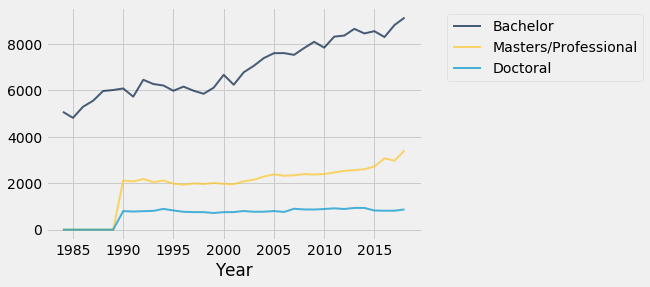

In [14]:
degrees_by_year.oplot()

In [15]:
degrees_by_year.show()

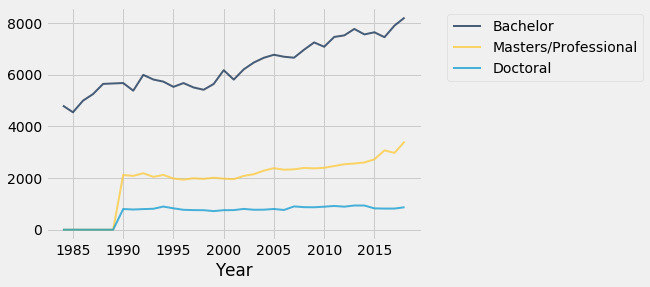

In [16]:
grads_by_year = TimeTable.by_time(degrees, 'Year', 'DegLvlDesc', 'Prorated Degrees Awarded Cnt')
grads_by_year.oplot()

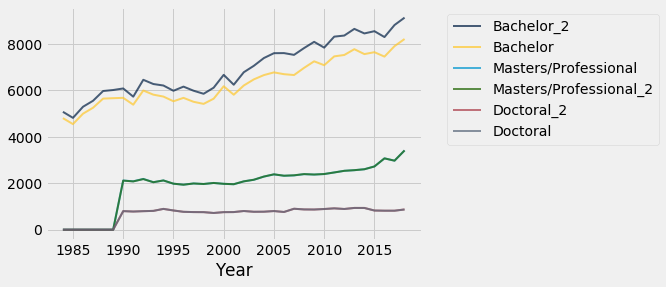

In [17]:
grads_by_year.join('Year', degrees_by_year).oplot()

In [18]:
grads = grads_by_year.join('Year', degrees_by_year).drop(["Masters/Professional_2", "Doctoral_2"])
grads.relabel('Bachelor_2', 'Bachelor Degrees').show()

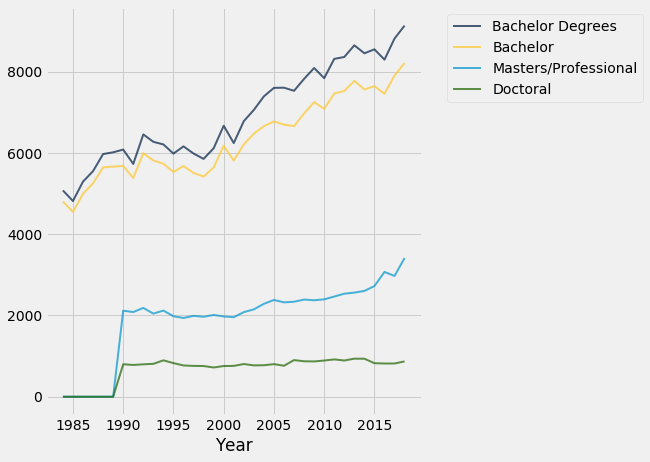

In [19]:
grads.oplot(height=7)

In [20]:
trend(grads)

Program              | Average | Growth   | Rel growth
Bachelor             | 7625.67 | 92.7667  | 1.22%
Bachelor Degrees     | 8490.78 | 107.433  | 1.27%
Doctoral             | 878.556 | -10.7667 | -1.23%
Masters/Professional | 2749.89 | 113.7    | 4.13%

In [21]:
grads.apply_all(lambda x: x/1500).after(2010)

Year  | Bachelor | Doctoral | Masters/Professional | Bachelor Degrees
2,010 | 4.72333  | 0.594    | 1.598                | 5.22733
2,011 | 4.97667  | 0.612667 | 1.644                | 5.54333
2,012 | 5.01667  | 0.594667 | 1.69067              | 5.57467
2,013 | 5.18267  | 0.624667 | 1.70867              | 5.766
2,014 | 5.042    | 0.624    | 1.736                | 5.63533
2,015 | 5.09667  | 0.550667 | 1.816                | 5.7
2,016 | 4.97     | 0.545333 | 2.048                | 5.53133
2,017 | 5.27067  | 0.545333 | 1.982                | 5.87733
2,018 | 5.47533  | 0.58     | 2.276                | 6.08933

# PhDs

In [22]:
grad_groups = [
 'Anc Hist & Medit Archae',
 'Applied Science & Tech',
 'Asian Studies',
 'Bioengineering',
 'Biophysics',
 'Biostatistics',
 'Buddhist Studies',
 'Comparative Biochemistry',
 'Computational Biology',
 'Endocrinology',
 'Energy & Resources',
 'Environ Health Sciences',
 'Environmental Planning',
 'Epidemiology',
 'Health Policy',
 'Infec Diseases & Immunity',
 'Jewish Studies',
 'Jurisprudence & Social Policy',
 'Latin American Studies',
 'Logic/Methodology of Science',
 'Medieval Studies',
 'Metabolic Biology',
 'Microbiology',
 'Molecular Toxicology',
 'Neuroscience',
 'Performance Studies',
 'Romance Lang & Lit',
 'Science & Math Education',
 'Sociology & Demography',
 'Vision Science',]

In [23]:
phds = degrees.where('DegLvl', 3)

In [24]:
phds

Academic Yr | DegLvl | DegLvlDesc | All Major Acad Hier Level Nm | Reporting Clg School Short Nm | Academic Division Short Nm | Academic Department Short Nm  | Major Short Nm            | Student Headcount | Prorated Degrees Awarded Cnt | Year
1989-90     | 3      | Doctoral   | All                          | Clg of Chemistry              | Clg of Chemistry           | Chem & Biomolecular Eng       | Chemical Engineering      | 16                | 16                           | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Chemistry              | Clg of Chemistry           | Chemistry                     | Chemistry                 | 69                | 69                           | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Bioengineering                | Bioengineering            | 1                 | 1                            | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Civil & Environmental Eng     | Civil Engineering         | 37                | 37                           | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Electrical Eng & Computer Sci | Computer Science          | 20                | 20                           | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Electrical Eng & Computer Sci | Electrical Eng & Comp Sci | 44                | 44                           | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Industrial Eng & Ops Research | Industrial Eng & Ops Rsch | 9                 | 9                            | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Materials Science & Eng       | Mat Sci & Mineral Eng     | 21                | 21                           | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Mechanical Engineering        | Mechanical Engineering    | 43                | 43                           | 1,990
1989-90     | 3      | Doctoral   | All                          | Clg of Engineering            | Clg of Engineering         | Mechanical Engineering        | Naval Architecture        | 3                 | 3                            | 1,990
... (2528 rows omitted)

In [25]:
phd_nm = list(np.unique(phds['Major Short Nm']))
phd_nm

['African American Studies',
 'Ag & Environmental Chem',
 'Ag & Resource Economics',
 'Anatomy',
 'Anc Hist & Medit Archae',
 'Anthropology',
 'Applied Mathematics',
 'Applied Science & Tech',
 'Architecture',
 'Asian Studies',
 'Astronomy',
 'Astrophysics',
 'Biochemistry',
 'Bioengineering',
 'Biophysics',
 'Biostatistics',
 'Botany',
 'Buddhist Studies',
 'Business Administration',
 'CNR Parasitology',
 'Chemical Engineering',
 'Chemistry',
 'Chinese Language',
 'City & Regional Planning',
 'Civil & Environmental Eng',
 'Civil Engineering',
 'Classical Archaeology',
 'Classics',
 'Comparative Biochemistry',
 'Comparative Literature',
 'Computational Biology',
 'Computer Science',
 'Demography',
 'Developmental Biology',
 'Doctor of Science of Law (JSD)',
 'Dramatic Art',
 'Earth & Planetary Science',
 'East Asian Languages',
 'Economics',
 'Education',
 'Educational Leadership Jnt Pgm',
 'Electrical Eng & Comp Sci',
 'Endocrinology',
 'Energy & Resources',
 'English',
 'Entomology',

In [26]:
# Number of PhD programs
len(phd_nm)

136

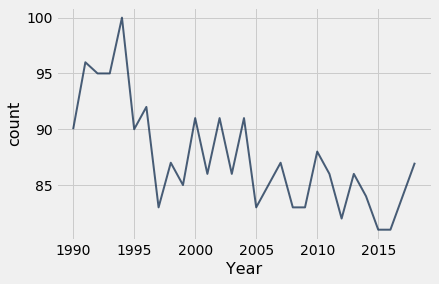

In [27]:
# Number of Active programs
phds.group('Year').plot('Year')

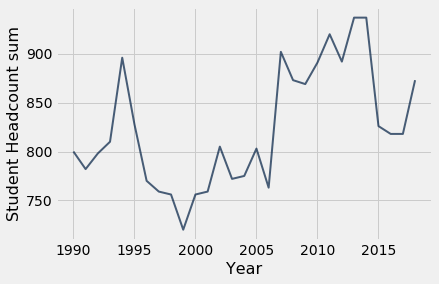

In [28]:
phds.select(['Year', 'Student Headcount']).group('Year', sum).plot('Year')

In [29]:
phds_by_year = TimeTable.by_time(phds, 'Year', 'Major Short Nm', 'Student Headcount')
dept_phds_by_year = TimeTable.by_time(phds, 'Year', 'Academic Department Short Nm', 'Student Headcount')
div_phds_by_year = TimeTable.by_time(phds, 'Year', 'Academic Division Short Nm', 'Student Headcount')

In [30]:
phds_by_year.show()

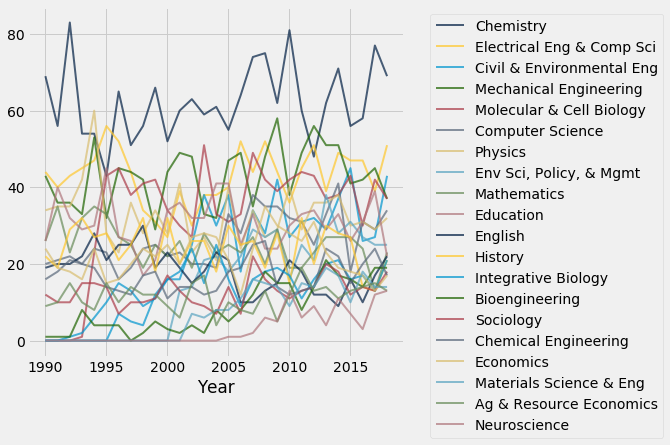

In [31]:
phds_by_year.top(20).oplot(height=6)

In [32]:
phds_by_year.apply_cols(sum)

African American Studies | Ag & Environmental Chem | Ag & Resource Economics | Anatomy | Anc Hist & Medit Archae | Anthropology | Applied Mathematics | Applied Science & Tech | Architecture | Asian Studies | Astronomy | Astrophysics | Biochemistry | Bioengineering | Biophysics | Biostatistics | Botany | Buddhist Studies | Business Administration | CNR Parasitology | Chemical Engineering | Chemistry | Chinese Language | City & Regional Planning | Civil & Environmental Eng | Civil Engineering | Classical Archaeology | Classics | Comparative Biochemistry | Comparative Literature | Computational Biology | Computer Science | Demography | Developmental Biology | Doctor of Science of Law (JSD) | Dramatic Art | Earth & Planetary Science | East Asian Languages | Economics | Education | Educational Leadership Jnt Pgm | Electrical Eng & Comp Sci | Endocrinology | Energy & Resources | English | Entomology | Env Sci, Policy, & Mgmt | Environ Health Sciences | Environmental Planning | Epidemiology | Ethnic Studies | Film and Media | French | Genetics | Geography | Geology | Geophysics | German | Grad Div Individual Major | Health Policy | Hispanic Lang & Lit | History | History of Art | Hlth Servs & Pol Analysis | Human Biodynamics | Immunology | Industrial Eng & Ops Rsch | Infec Diseases & Immunity | Info Mgmt & Systems | Integrative Biology | Italian | Italian Studies | Japanese Language | Jewish Studies | Jurisprudence & Social Policy | Landscape Arch & Env Plan | Latin American Studies | Law (JD) | Library & Info Studies | Linguistics | Logic/Methodology of Science | Mat Sci & Mineral Eng | Materials Science & Eng | Mathematics | Mechanical Engineering | Medical Anthropology | Medical Physics | Medieval Studies | Metabolic Biology | Microbiology | Mol & Phys Plant Biology | Molecular & Biochem Nutrition | Molecular & Cell Biology | Molecular Biology | Molecular Toxicology | Music | Naval Architecture | Near Eastern Religions | Near Eastern Studies | Neurobiology | Neuroscience | Nuclear Engineering | Nutrition | Ocean Engineering | Paleontology | Parasitology | Performance Studies | Philosophy | Physical Education | Physics | Physiological Optics | Physiology | Plant Biology | Plant Pathology | Political Science | Psychology | Public Health | Public Policy | Rhetoric | Romance Lang & Lit | Romance Philology | SPH Microbiology | Scandinavian Lang & Lit | Science & Math Education | Slavic Lang & Lit | Social Welfare | Sociology | Sociology & Demography | Soil Science | South & SE Asian Studies | Special Education | Statistics | Vision Science | Wildland Resource Science | Wood Science & Technology | Zoology
42                       | 21                      | 333                     | 4       | 62                      | 411          | 64                  | 92                     | 188          | 9             | 43        | 89           | 57           | 250            | 229        | 104           | 20     | 21               | 377                     | 1                | 495                  | 1,804     | 27               | 201                      | 610                       | 269               | 11                    | 95       | 86                       | 247                    | 2                     | 761              | 64         | 1                     | 34                             | 33           | 114                       | 15                   | 639       | 892       | 23                             | 1,244                     | 55            | 167                | 533     | 89         | 431                     | 103                     | 28                     | 247          | 179            | 19             | 86     | 34       | 182       | 61      | 48         | 127    | 60                        | 12            | 133                 | 703     | 174            | 110                       | 14                | 4          | 208                       | 46                        | 44                  | 395                 | 19  

In [33]:
dormant(phds_by_year, 10)

['Anatomy',
 'Astronomy',
 'Biochemistry',
 'Botany',
 'CNR Parasitology',
 'Developmental Biology',
 'Dramatic Art',
 'East Asian Languages',
 'Entomology',
 'Genetics',
 'Geology',
 'Geophysics',
 'Human Biodynamics',
 'Immunology',
 'Italian',
 'Library & Info Studies',
 'Medical Physics',
 'Mol & Phys Plant Biology',
 'Molecular Biology',
 'Naval Architecture',
 'Neurobiology',
 'Nutrition',
 'Ocean Engineering',
 'Paleontology',
 'Parasitology',
 'Physical Education',
 'Physiological Optics',
 'Physiology',
 'Plant Pathology',
 'Romance Philology',
 'SPH Microbiology',
 'Soil Science',
 'Wood Science & Technology',
 'Zoology']

In [34]:
# Number of dormant programs
len(dormant(phds_by_year, 10))

34

In [35]:
len(grad_groups)

30

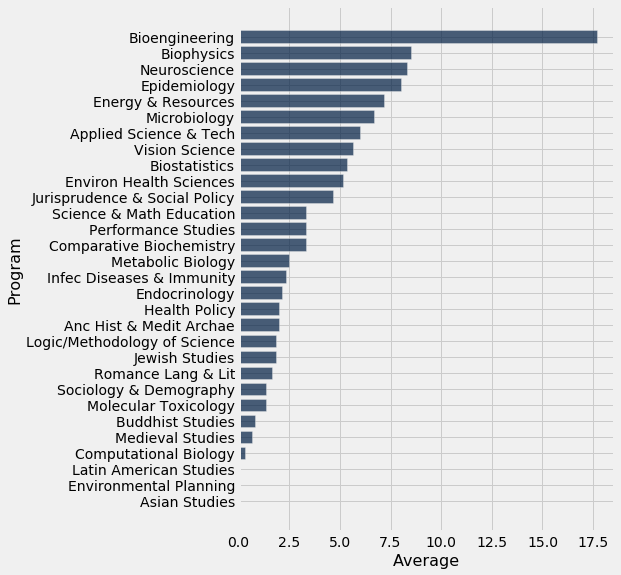

In [36]:
gg_phds_by_year = phds_by_year.select(['Year'] + grad_groups)
ave_grads(gg_phds_by_year, 2013).barh("Program", height=9)

In [37]:
# Remove Dormant PhD programs, i.e., those you have not had a graduate in 10 years

phds_by_year = phds_by_year.drop(dormant(phds_by_year, 10))

In [38]:
pgms = transpose(phds_by_year.apply_cols(np.mean), ["Program", "Average"]).sort("Average", descending=True)
pgms.show()

In [39]:
pgms.num_rows

102

In [40]:
gg_phds_by_year = phds_by_year.select(['Year'] + grad_groups)
gg_phds_by_year.show()

In [41]:
gg_phds_by_year.to_csv("gg_by_year.csv")

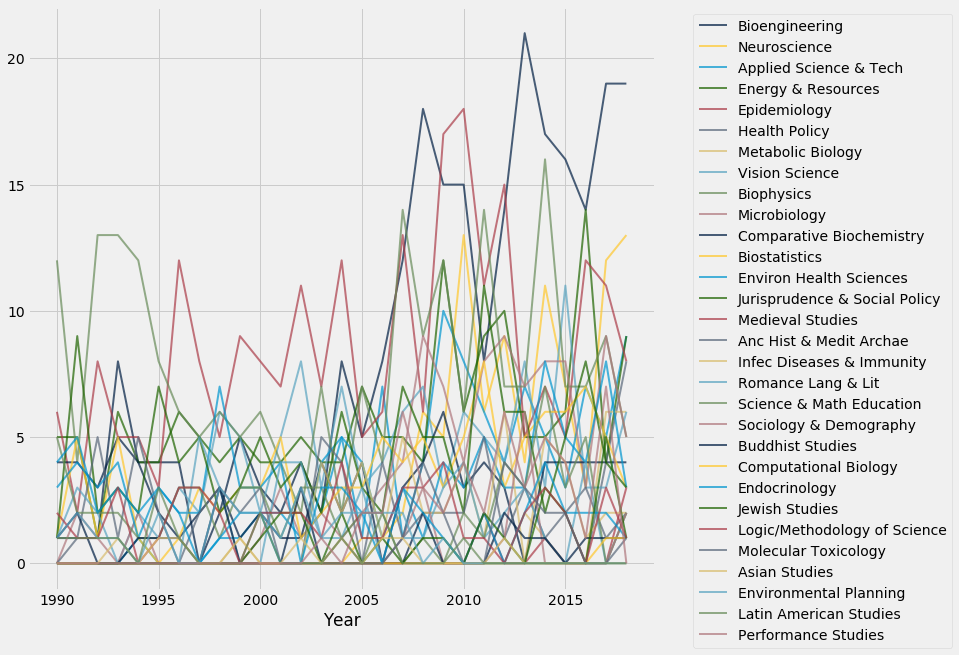

In [42]:
gg_phds_by_year.oplot(height=10, width=10)

In [43]:
# Number of Active Graduate Groups versus total
len(gg_phds_by_year)-1, len(phds_by_year)-1

(30, 102)

In [44]:
dep_phds_by_year = phds_by_year.drop(grad_groups)
dep_phds_by_year

Year  | African American Studies | Ag & Environmental Chem | Ag & Resource Economics | Anthropology | Applied Mathematics | Architecture | Astrophysics | Business Administration | Chemical Engineering | Chemistry | Chinese Language | City & Regional Planning | Civil & Environmental Eng | Civil Engineering | Classical Archaeology | Classics | Comparative Literature | Computer Science | Demography | Doctor of Science of Law (JSD) | Earth & Planetary Science | Economics | Education | Educational Leadership Jnt Pgm | Electrical Eng & Comp Sci | English | Env Sci, Policy, & Mgmt | Ethnic Studies | Film and Media | French | Geography | German | Grad Div Individual Major | Hispanic Lang & Lit | History | History of Art | Hlth Servs & Pol Analysis | Industrial Eng & Ops Rsch | Info Mgmt & Systems | Integrative Biology | Italian Studies | Japanese Language | Landscape Arch & Env Plan | Law (JD) | Linguistics | Mat Sci & Mineral Eng | Materials Science & Eng | Mathematics | Mechanical Engineering | Medical Anthropology | Molecular & Biochem Nutrition | Molecular & Cell Biology | Music | Near Eastern Religions | Near Eastern Studies | Nuclear Engineering | Philosophy | Physics | Plant Biology | Political Science | Psychology | Public Health | Public Policy | Rhetoric | Scandinavian Lang & Lit | Slavic Lang & Lit | Social Welfare | Sociology | South & SE Asian Studies | Special Education | Statistics | Wildland Resource Science
1,990 | 0                        | 0                       | 9                       | 17           | 1                   | 8            | 0            | 12                      | 16                   | 69        | 0                | 4                        | 0                         | 37                | 0                     | 6        | 7                      | 20               | 4          | 0                              | 0                         | 24        | 26        | 0                              | 44                        | 19      | 0                       | 4              | 0              | 3      | 6         | 5      | 9                         | 3                   | 22      | 4              | 0                         | 9                         | 0                   | 0                   | 0               | 0                 | 0                         | 5        | 6           | 21                    | 0                       | 26          | 43                     | 0                    | 0                             | 0                        | 6     | 1                      | 4                    | 6                   | 1          | 34      | 0             | 22                | 19         | 6             | 2             | 3        | 0                       | 4                 | 13             | 12        | 0                        | 1                 | 7          | 12
1,991 | 0                        | 0                       | 10                      | 17           | 5                   | 3            | 0            | 14                      | 18                   | 56        | 0                | 9                        | 0                         | 25                | 0                     | 5        | 7                      | 21               | 3          | 0                              | 0                         | 19        | 40        | 0                              | 40                        | 20      | 0                       | 3              | 0              | 2      | 7         | 6      | 5                         | 2                   | 19      | 4              | 1                         | 6                         | 0                   | 0                   | 0               | 0                 | 0                         | 2        | 5           | 19                    | 0                       | 35          | 36                     | 2                    | 0                             | 0                        | 5     | 2                      | 4                    | 8

In [45]:
dep_phds_by_year.order_cols()

Year  | Chemistry | Electrical Eng & Comp Sci | Civil & Environmental Eng | Mechanical Engineering | Molecular & Cell Biology | Computer Science | Physics | Env Sci, Policy, & Mgmt | Mathematics | Education | English | History | Integrative Biology | Sociology | Chemical Engineering | Economics | Materials Science & Eng | Ag & Resource Economics | Psychology | Anthropology | Business Administration | Industrial Eng & Ops Rsch | Nuclear Engineering | Philosophy | Political Science | Earth & Planetary Science | Plant Biology | Rhetoric | Linguistics | Music | Statistics | African American Studies | Architecture | History of Art | Public Health | Astrophysics | City & Regional Planning | Doctor of Science of Law (JSD) | Ethnic Studies | Social Welfare | Special Education | Geography | German | Comparative Literature | Demography | Film and Media | French | Hispanic Lang & Lit | Landscape Arch & Env Plan | Near Eastern Studies | Scandinavian Lang & Lit | Applied Mathematics | Info Mgmt & Systems | Italian Studies | Public Policy | Chinese Language | Classics | Grad Div Individual Major | Japanese Language | Near Eastern Religions | Slavic Lang & Lit | Ag & Environmental Chem | Civil Engineering | Classical Archaeology | Educational Leadership Jnt Pgm | Hlth Servs & Pol Analysis | Law (JD) | Mat Sci & Mineral Eng | Medical Anthropology | Molecular & Biochem Nutrition | South & SE Asian Studies | Wildland Resource Science
1,990 | 69        | 44                        | 0                         | 43                     | 0                        | 20               | 34      | 0                       | 26          | 26        | 19      | 22      | 0                   | 12        | 16                   | 24        | 0                       | 9                       | 19         | 17           | 12                      | 9                         | 6                   | 1          | 22                | 0                         | 0             | 3        | 6           | 6     | 7          | 0                        | 8            | 4              | 6             | 0            | 4                        | 0                              | 4              | 13             | 1                 | 6         | 5      | 7                      | 4          | 0              | 3      | 3                   | 0                         | 4                    | 0                       | 1                   | 0                   | 0               | 2             | 0                | 6        | 9                         | 0                 | 1                      | 4                 | 0                       | 37                | 0                     | 0                              | 0                         | 5        | 21                    | 0                    | 0                             | 0                        | 12
1,991 | 56        | 40                        | 0                         | 36                     | 0                        | 21               | 35      | 0                       | 35          | 40        | 20      | 19      | 0                   | 10        | 18                   | 19        | 0                       | 10                      | 12         | 17           | 14                      | 6                         | 8                   | 9          | 18                | 0                         | 0             | 3        | 5           | 5     | 13         | 0                        | 3            | 4              | 10            | 0            | 9                        | 0                              | 3              | 13             | 2                 | 7         | 6      | 7                      | 3          | 0              | 2      | 2                   | 0                         | 4                    | 1                       | 5                   | 0                   | 0               | 2             | 0                | 5        | 5                         | 0                 | 2                     

In [46]:
gg_phds_by_year.order_cols()

Year  | Bioengineering | Neuroscience | Applied Science & Tech | Energy & Resources | Epidemiology | Health Policy | Metabolic Biology | Vision Science | Biophysics | Microbiology | Comparative Biochemistry | Biostatistics | Environ Health Sciences | Jurisprudence & Social Policy | Medieval Studies | Anc Hist & Medit Archae | Infec Diseases & Immunity | Romance Lang & Lit | Science & Math Education | Sociology & Demography | Buddhist Studies | Computational Biology | Endocrinology | Jewish Studies | Logic/Methodology of Science | Molecular Toxicology | Asian Studies | Environmental Planning | Latin American Studies | Performance Studies
1,990 | 1              | 0            | 0                      | 5                  | 6            | 0             | 0                 | 0              | 12         | 0            | 4                        | 1             | 3                       | 1                             | 0                | 0                       | 0                         | 1                  | 5                        | 0                      | 1                | 0                     | 4             | 0              | 2                            | 0                    | 0             | 1                      | 1                      | 0
1,991 | 1              | 0            | 0                      | 5                  | 2            | 0             | 0                 | 0              | 4          | 2            | 4                        | 5             | 4                       | 9                             | 0                | 1                       | 0                         | 3                  | 2                        | 0                      | 2                | 0                     | 5             | 0              | 1                            | 0                    | 0             | 2                      | 1                      | 0
1,992 | 1              | 0            | 0                      | 1                  | 8            | 0             | 0                 | 0              | 13         | 1            | 3                        | 1             | 3                       | 2                             | 0                | 5                       | 0                         | 2                  | 2                        | 0                      | 0                | 0                     | 2             | 0              | 1                            | 0                    | 0             | 1                      | 1                      | 0
1,993 | 8              | 0            | 0                      | 6                  | 5            | 0             | 0                 | 0              | 13         | 0            | 5                        | 5             | 4                       | 3                             | 0                | 1                       | 0                         | 0                  | 2                        | 0                      | 0                | 0                     | 3             | 0              | 3                            | 0                    | 1             | 1                      | 1                      | 0
1,994 | 4              | 0            | 1                      | 4                  | 5            | 0             | 0                 | 2              | 12         | 2            | 4                        | 1             | 1                       | 2                             | 0                | 5                       | 0                         | 0                  | 1                        | 0                      | 1                | 0                     | 2             | 0              | 0                            | 0                    | 0             | 0                      | 0                      | 0
1,995 | 4              | 0            | 0                      | 4                  | 3            | 0             | 0                 | 1              | 8          | 0            | 2                        | 0          

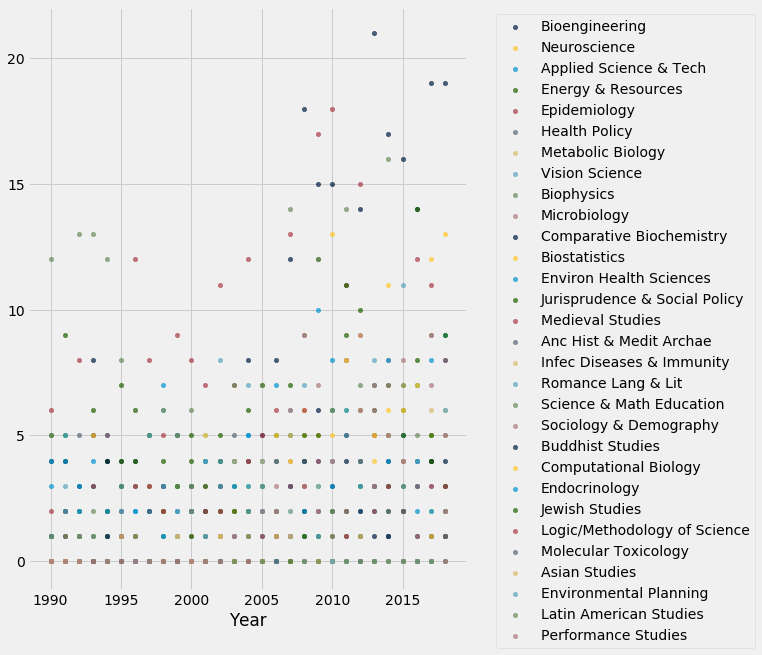

In [47]:
gg_phds_by_year.order_cols().scatter('Year',height=10, width=7)

In [48]:
# Phd Rates by program
ave_grads(phds_by_year).show()

In [49]:
# PhD rates by department
ave_grads(dept_phds_by_year).show()

In [50]:
ave_grads(gg_phds_by_year).show()

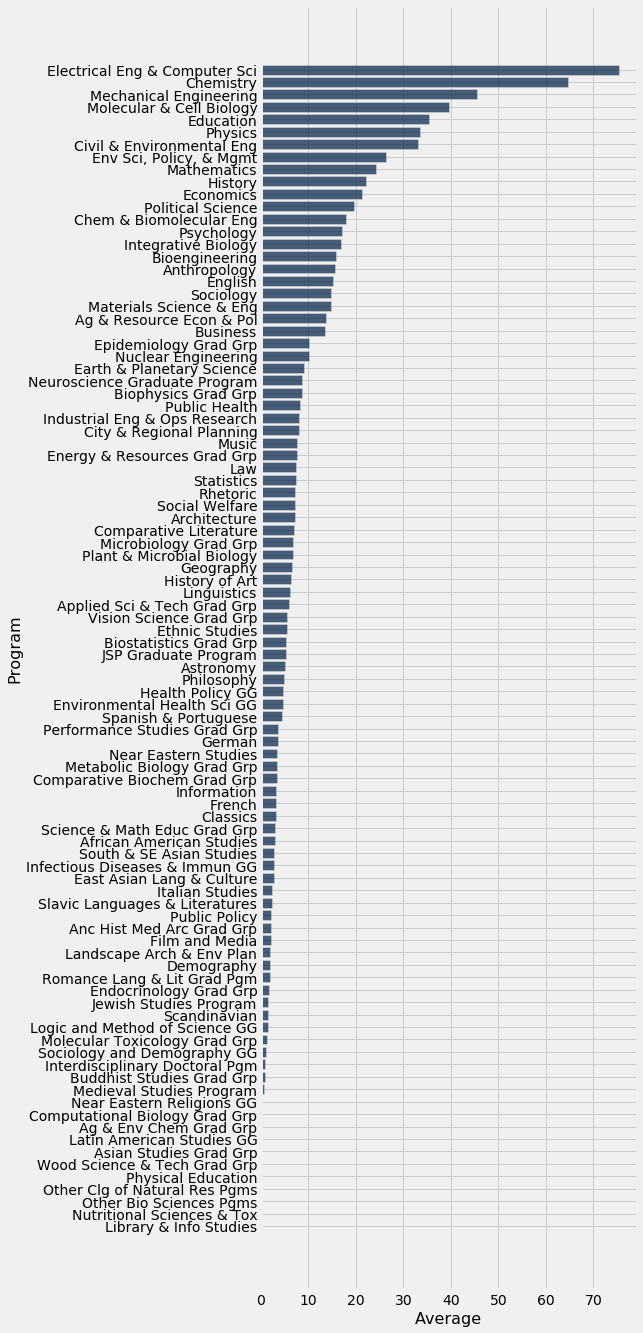

In [51]:
ave_grads(dept_phds_by_year, 2010).barh("Program", height=22)

In [52]:
dept_phds_by_year.order_cols().show()

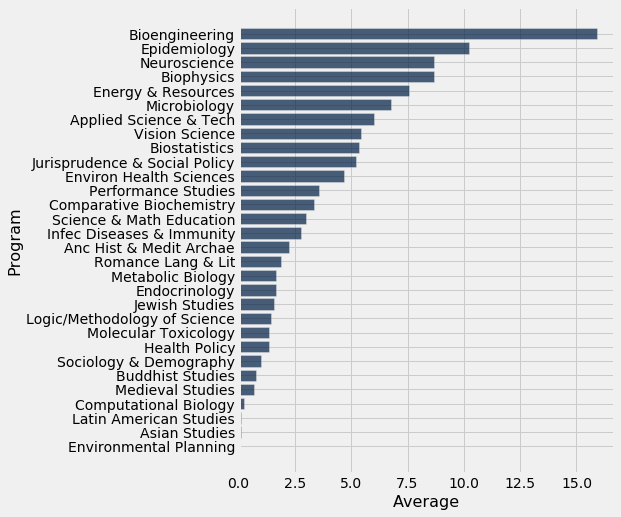

In [53]:
ave_grads(gg_phds_by_year.after(2008)).barh("Program", height=8)

### By academic unit

In [54]:
ave_grads(dept_phds_by_year.after(2000)).show()

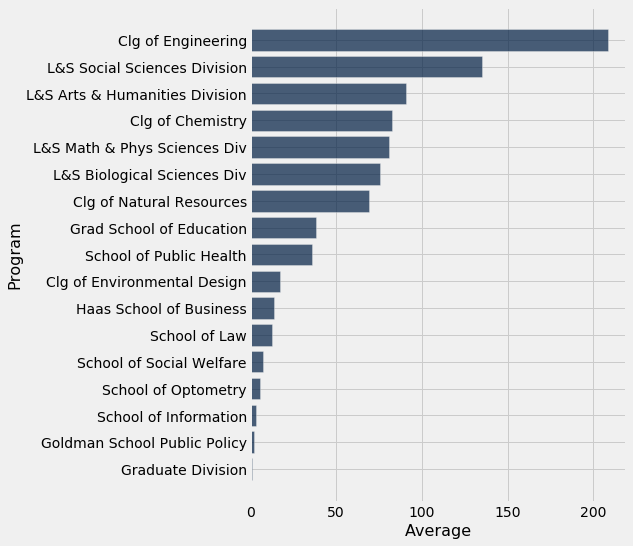

In [55]:
ave_grads(div_phds_by_year).barh('Program')

# Masters Degrees

In [56]:
ms = degrees.where('DegLvl', 2)
ms_by_year = TimeTable.by_time(ms, 'Year', 'Major Short Nm', 'Student Headcount')
ms_by_year = ms_by_year.drop(dormant(ms_by_year, 5))
dept_ms_by_year = TimeTable.by_time(ms, 'Year', 'Academic Department Short Nm', 'Student Headcount')
div_ms_by_year = TimeTable.by_time(ms, 'Year', 'Academic Division Short Nm', 'Student Headcount')
div_ms_by_year = div_ms_by_year.drop(dormant(div_ms_by_year, 5))

In [57]:
def masters_div(since):
    since = max(1990, since)
    since = min(since, 2016)
    return ave_grads(div_ms_by_year.after(since)).barh('Program')

In [58]:
interact(masters_div, since=widgets.IntSlider(min=1990,max=2016,step=1,value=10));

interactive(children=(IntSlider(value=1990, description='since', max=2016, min=1990), Output()), _dom_classes=…

In [59]:
dept_ms_by_year.after(2013).order_cols()

Year  | Law  | Business | Civil & Environmental Eng | Public Health | Information | Mechanical Engineering | Electrical Eng & Computer Sci | Public Policy | Education | Social Welfare | Bioengineering | Optometry | Journalism | Physics | Architecture | Industrial Eng & Ops Research | City & Regional Planning | Statistics | Chem & Biomolecular Eng | Bioengineering-UCSF Grad Grp | Landscape Arch & Env Plan | Materials Science & Eng | Nuclear Engineering | Development Practice Grad Grp | Health & Medical Sci Grad Grp | Energy & Resources Grad Grp | History | Sociology | Art Practice | Mathematics | Psychology | Chemistry | Global Studies Grad Grp | Political Science | Urban Design Grad Grp | Astronomy | Biostatistics Grad Grp | Classics | Asian Studies Grad Grp | Economics | Linguistics | Earth & Planetary Science | English | Environmental Health Sci GG | Integrative Biology | Near Eastern Studies | Rhetoric | African American Studies | Anc Hist Med Arc Grad Grp | Comparative Literature | Env Sci, Policy, & Mgmt | Epidemiology Grad Grp | German | Italian Studies | Molecular & Cell Biology | Music | Range Management Grad Grp | Slavic Languages & Literatures | Spanish & Portuguese | Applied Sci & Tech Grad Grp | Demography | East Asian Lang & Culture | Endocrinology Grad Grp | Film and Media | Folklore Grad Grp | French | History of Art | Latin American Studies GG | Molecular Toxicology Grad Grp | Scandinavian | South & SE Asian Studies | Ag & Env Chem Grad Grp | Ag & Resource Econ & Pol | Anthropology | Biophysics Grad Grp | Comparative Biochem Grad Grp | Ethnic Studies | Geography | Infectious Diseases & Immun GG | Interdisciplinary Doctoral Pgm | JSP Graduate Program | Library & Info Studies | Metabolic Biology Grad Grp | Microbiology Grad Grp | Neuroscience Graduate Program | Nutritional Sciences & Tox | Other Clg of Natural Res Pgms | Other Env Design Programs | Performance Studies Grad Grp | Philosophy | Physical Education | Plant & Microbial Biology | Vision Science Grad Grp | Wood Science & Tech Grad Grp
2,013 | 504  | 635      | 165                       | 128           | 40          | 84                     | 71                            | 85            | 94        | 100            | 17             | 66        | 47         | 23      | 64           | 56                            | 39                       | 39         | 9                       | 0                            | 20                        | 21                      | 10                  | 0                             | 14                            | 8                           | 15      | 19        | 7            | 7           | 9          | 7         | 1                       | 8                 | 8                     | 8         | 6                      | 7        | 7                      | 1         | 9           | 5                         | 4       | 2                           | 2                   | 0                    | 12       | 4                        | 1                         | 1                      | 4                       | 1                     | 3      | 0               | 2                        | 10    | 1                         | 6                              | 2                    | 2                           | 7          | 0                         | 1                      | 4              | 3                 | 0      | 1              | 2                         | 0                             | 1            | 1                        | 0                      | 9                        | 4            | 0                   | 1                            | 7              | 0         | 0                              | 0                              | 0                    | 0                      | 0                          | 1                     | 1                             | 0                          | 0                             | 0                         | 0                            | 0          | 0                 

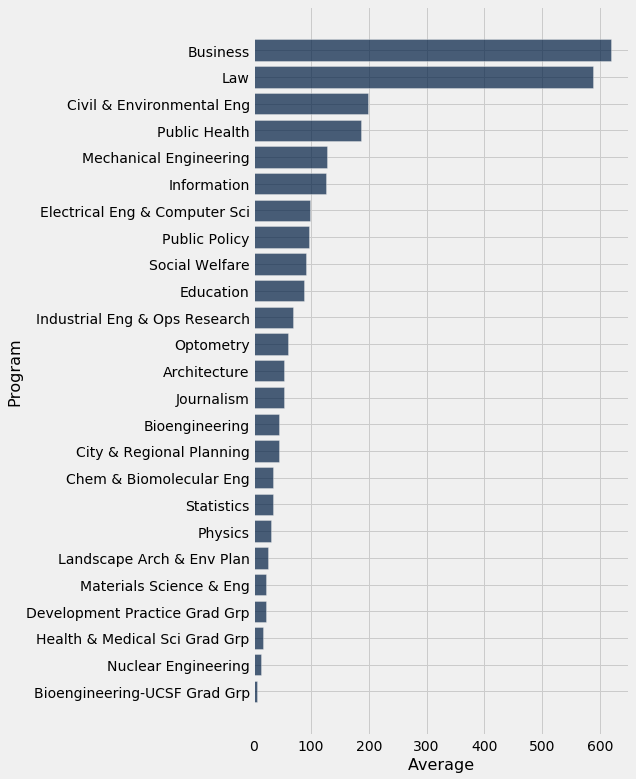

In [60]:
ave_grads(dept_ms_by_year.after(2014).top(25)).barh('Program')

In [61]:
len(ms_by_year)

107

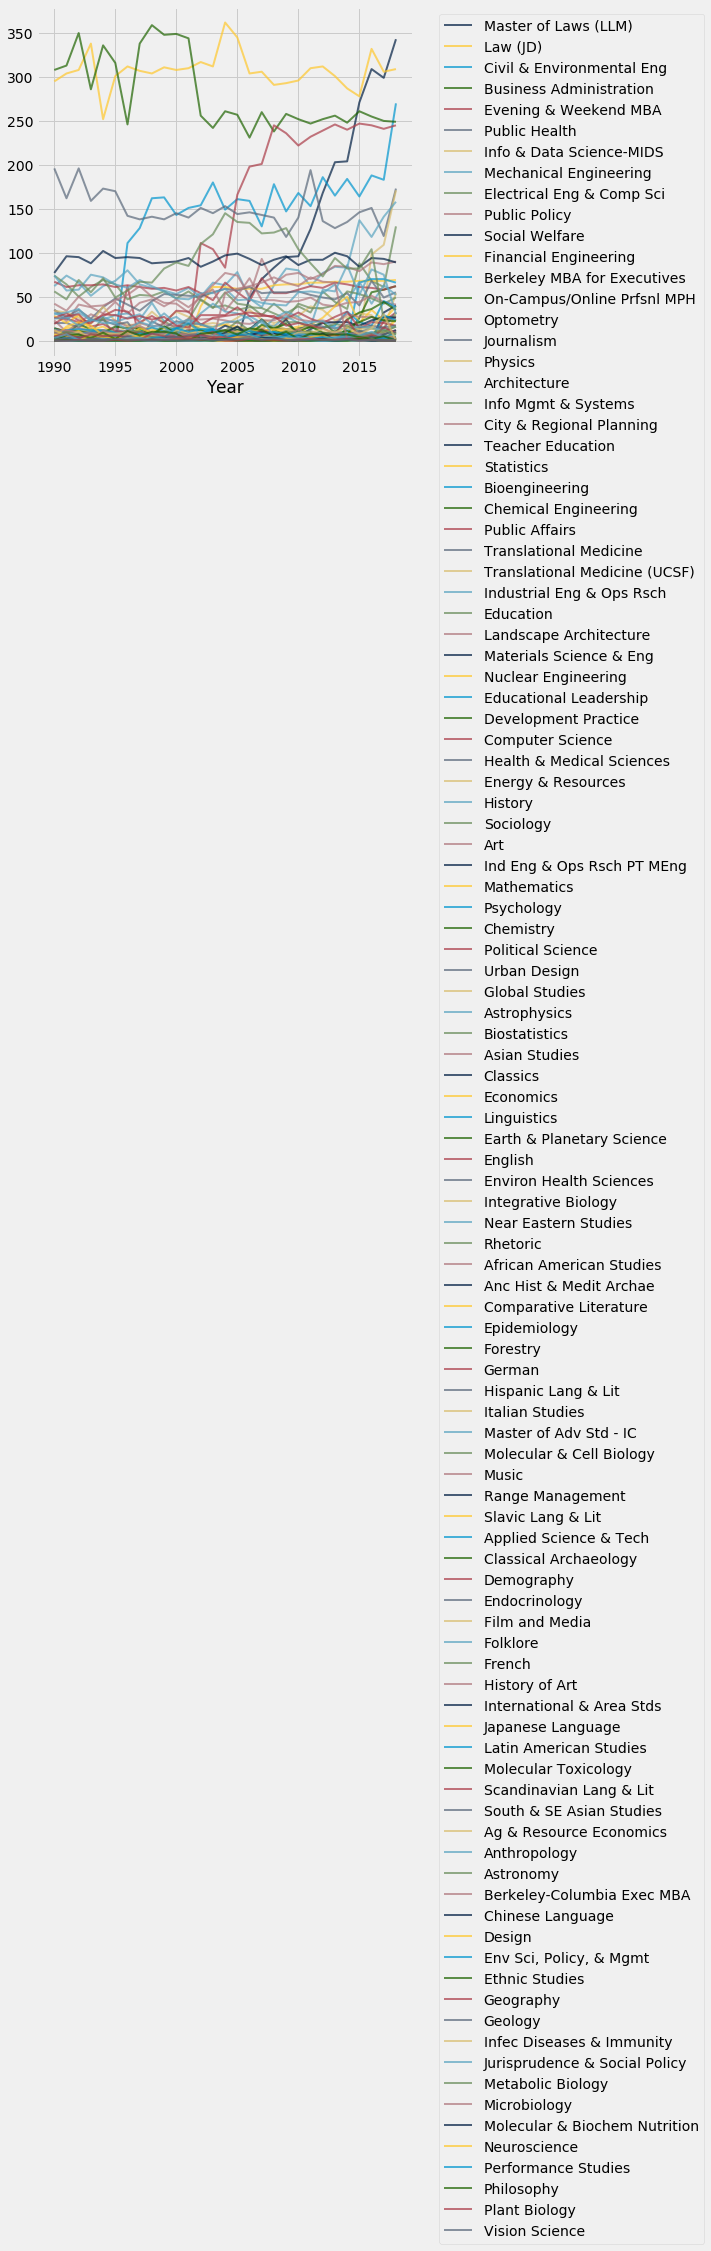

In [62]:
ms_by_year.oplot(height=6)

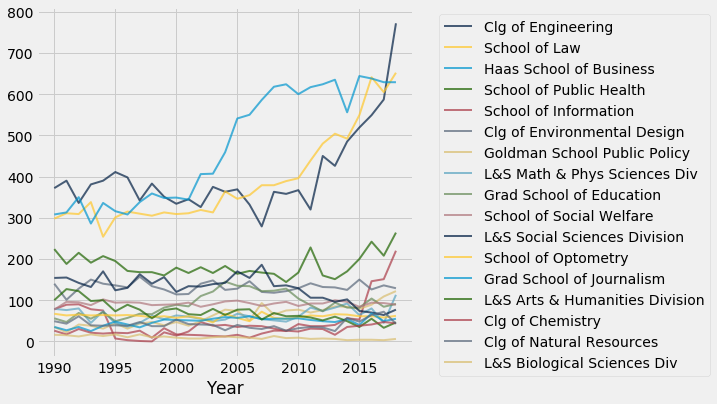

In [63]:
div_ms_by_year.oplot(height=6)

In [64]:
def ratio_at_times(ttbl, reftime, valtime):
    ref = ttbl.where(ttbl.time_column, reftime)
    val = ttbl.where(ttbl.time_column, valtime)
    res = Table(ttbl.labels)
    res.append(ref)
    res.append(val)
    ratio = val.ratio(ref)
    ratio[ref.time_column] = "Ratio"
    res.append(ratio)
    return transpose(res.drop(val.time_column), ["label", str(reftime), str(valtime), "ratio"])


In [65]:
ratio_at_times(div_ms_by_year, 2008, 2018).sort('ratio', descending=True).show()

In [66]:
ratio_at_times(ms_by_year, 2008, 2018).where('2018').sort('ratio', descending=True).show()

/Users/culler/devel/DataScienceTableDemos/CalGrads/timetable.py:95: RuntimeWarning: divide by zero encountered in true_divide
  rtbl[label] = self[label] / tbl_denom[label]
/Users/culler/devel/DataScienceTableDemos/CalGrads/timetable.py:95: RuntimeWarning: invalid value encountered in true_divide
  rtbl[label] = self[label] / tbl_denom[label]


In [67]:
div_ms_by_year.where(div_ms_by_year.time_column, 2018)

Year  | Clg of Chemistry | Clg of Engineering | Clg of Environmental Design | Clg of Natural Resources | Goldman School Public Policy | Grad School of Education | Grad School of Journalism | Haas School of Business | L&S Arts & Humanities Division | L&S Biological Sciences Div | L&S Math & Phys Sciences Div | L&S Social Sciences Division | School of Information | School of Law | School of Optometry | School of Public Health | School of Social Welfare
2,018 | 44               | 772                | 129                         | 43                       | 122                          | 91                       | 55                        | 629                     | 46                             | 6                           | 113                          | 77                           | 220                   | 652           | 62                  | 264                     | 89

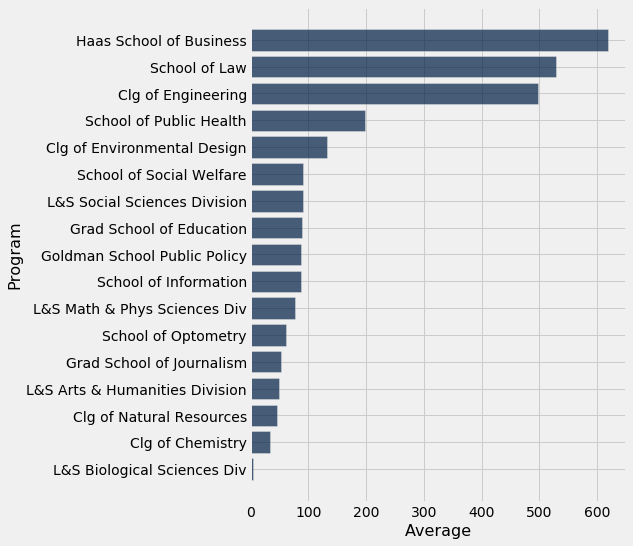

In [68]:
ave_grads(div_ms_by_year.after(2000)).barh('Program')

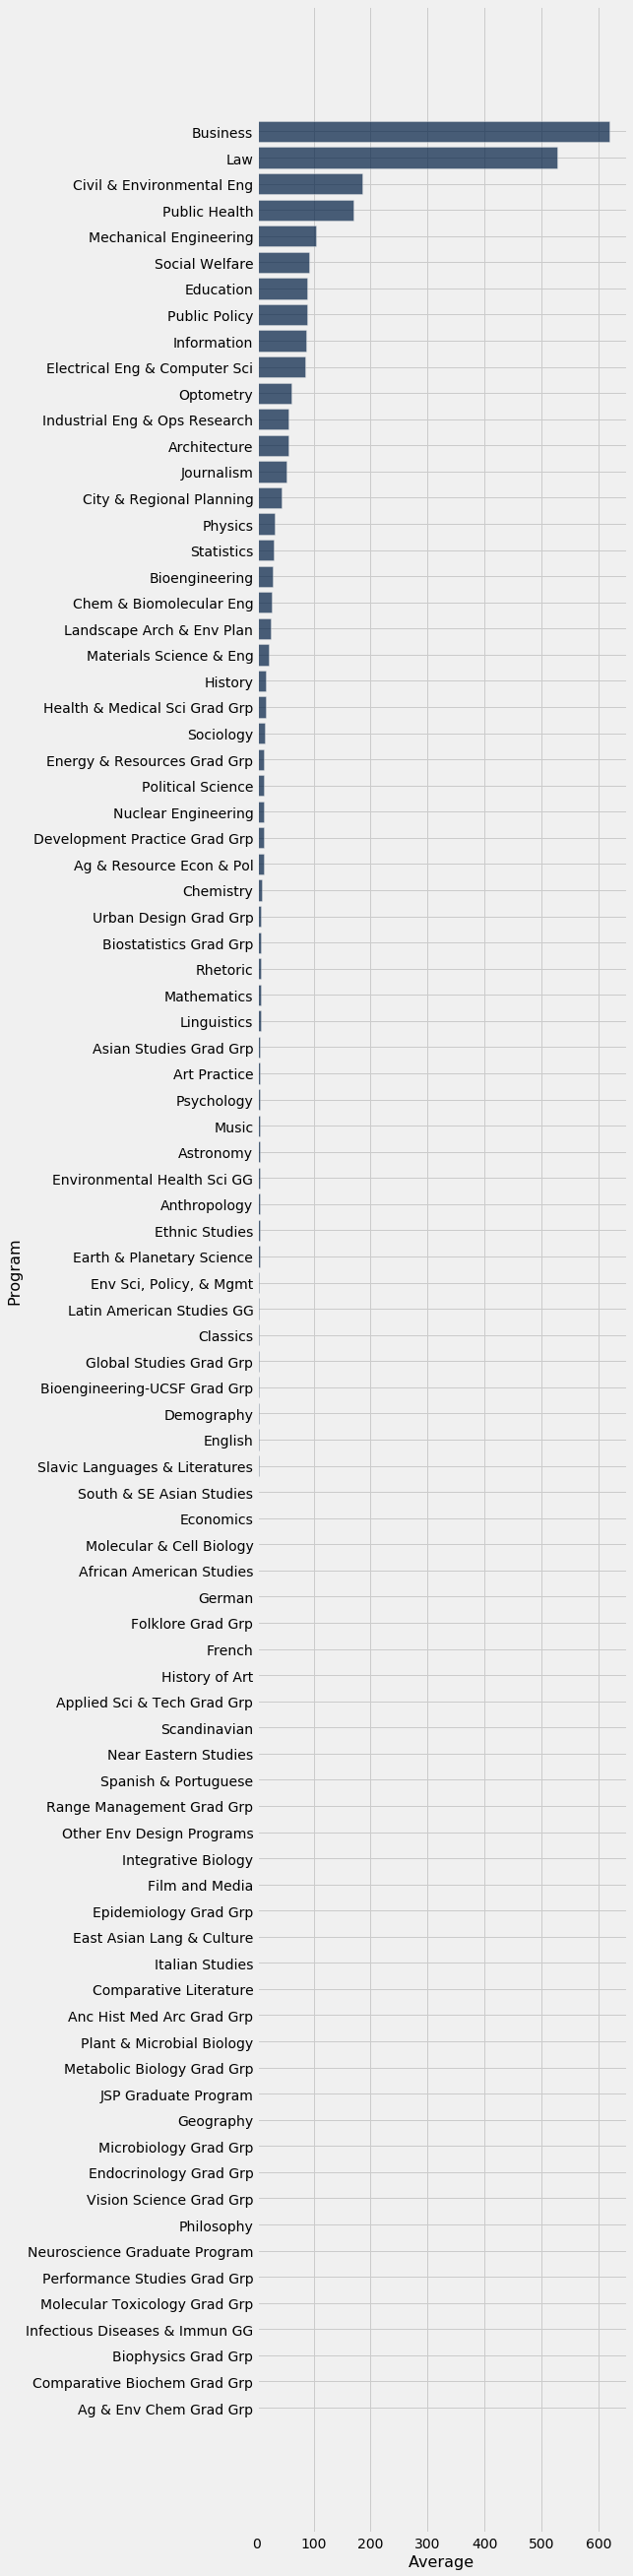

In [69]:
ave_grads(dept_ms_by_year).where("Average").barh('Program')

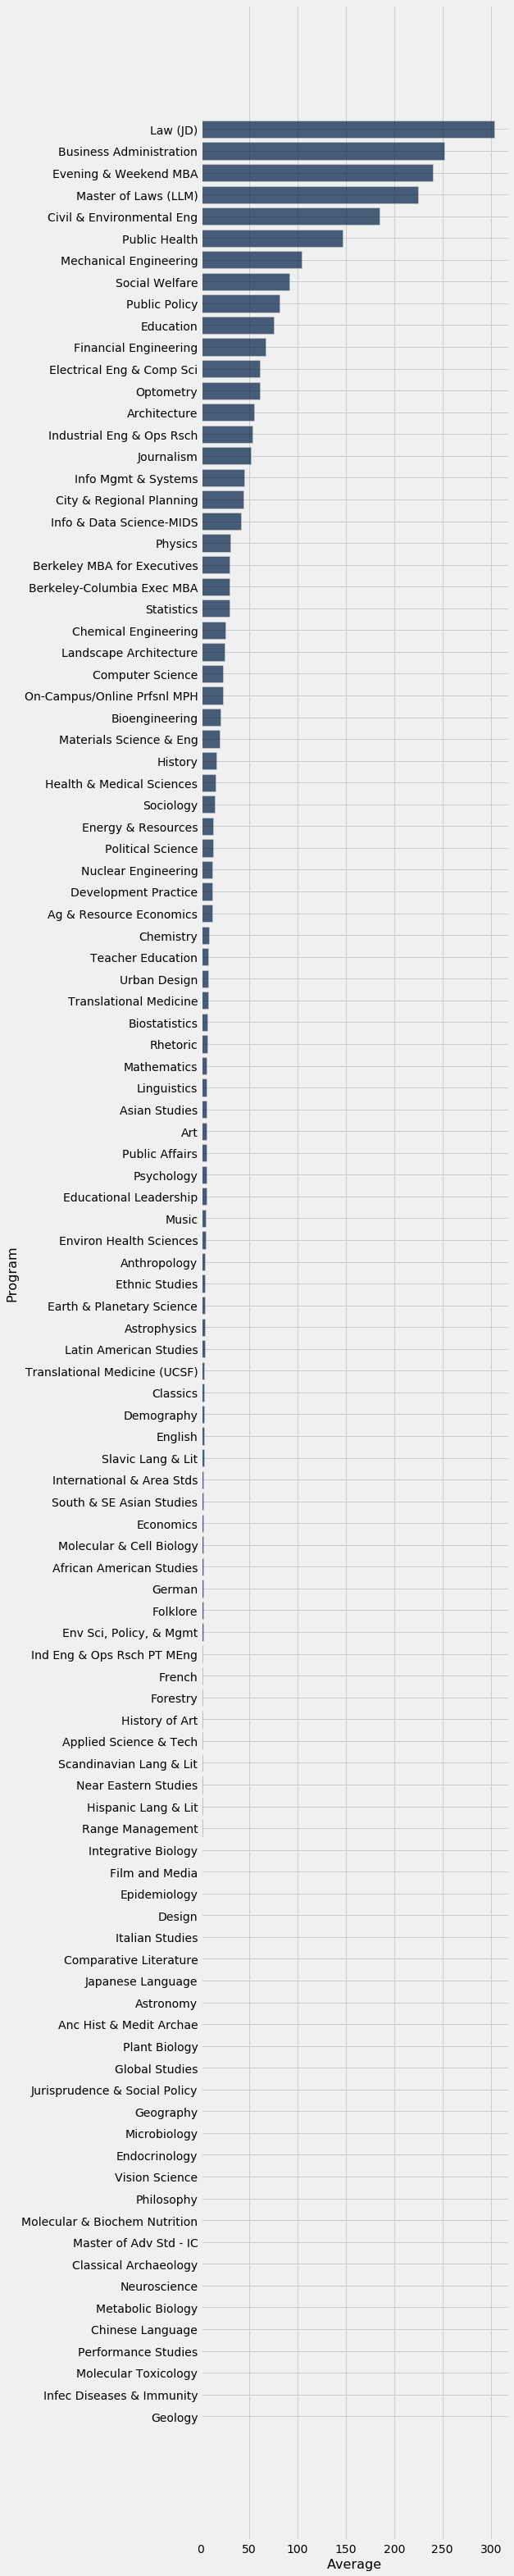

In [70]:
ave_grads(ms_by_year).barh('Program')

# Bachelors Degrees

In [71]:
BA = degrees.where('DegLvl', 1)
BA_by_year = TimeTable.by_time(BA, 'Year', 'Major Short Nm', 'Student Headcount')
dept_BA_by_year = TimeTable.by_time(BA, 'Year', 'Academic Department Short Nm', 'Student Headcount')
div_BA_by_year = TimeTable.by_time(BA, 'Year', 'Academic Division Short Nm', 'Student Headcount')

In [72]:
len(BA_by_year.categories), len(dormant(BA_by_year, 10))

(226, 71)

In [73]:
len(dept_BA_by_year.categories), len(dormant(dept_BA_by_year, 10)), dormant(dept_BA_by_year, 10)

(77,
 7,
 ['Journalism',
  'L&S Undeclared',
  'Optometry',
  'Other Chemistry Programs',
  'Other Clg of Natural Res Pgms',
  'Other EVCP Programs',
  'Wood Science & Tech Grad Grp'])

In [74]:
len(div_BA_by_year.categories), len(dormant(div_BA_by_year, 10)), dormant(div_BA_by_year, 10)

(15,
 4,
 ['Grad School of Journalism',
  'L&S Undeclared',
  'Other EVCP Programs',
  'School of Optometry'])

In [75]:
# Drop programs that have been dormant for 10 years
BA_by_year = BA_by_year.drop(dormant(BA_by_year, 10))
dept_BA_by_year = dept_BA_by_year.drop(dormant(dept_BA_by_year, 10))
div_BA_by_year = div_BA_by_year.drop(dormant(div_BA_by_year, 10))

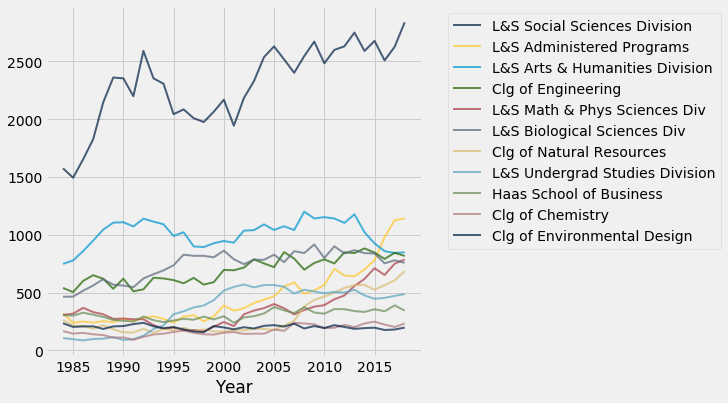

In [76]:
div_BA_by_year.oplot(height=6)

In [77]:
def BA_div(since):
    since = min(max(1983, since), 2018)
    return ave_grads(div_BA_by_year.after(since)).barh('Program', height=4)

In [78]:
interact(BA_div, since=widgets.IntSlider(min=1990,max=2016,step=1,value=10));

interactive(children=(IntSlider(value=1990, description='since', max=2016, min=1990), Output()), _dom_classes=…

In [79]:
trend(div_BA_by_year).sort('Rel growth').show()

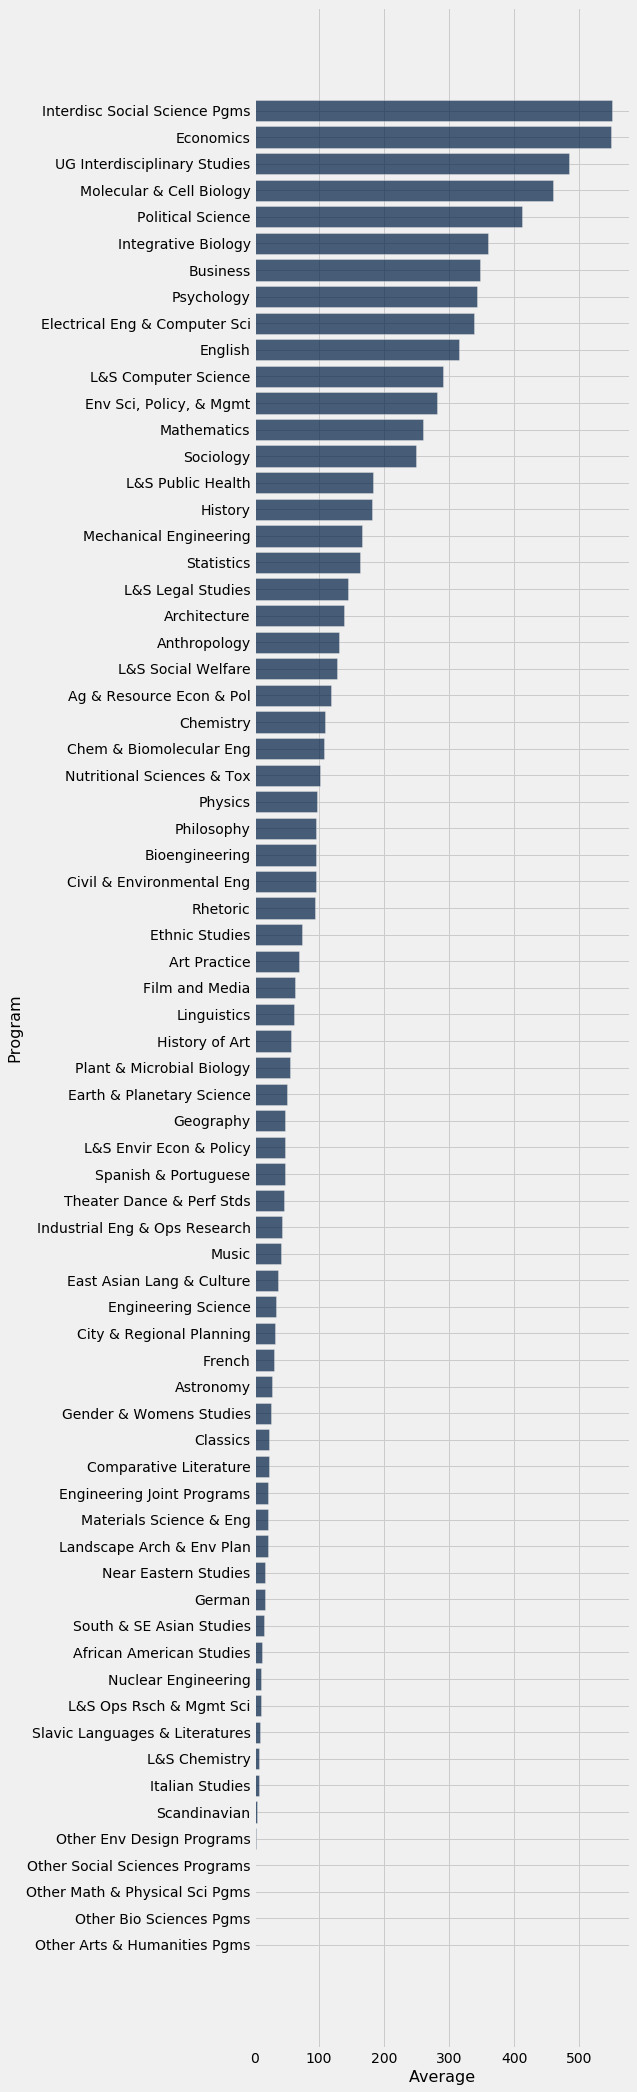

In [80]:
ave_grads(dept_BA_by_year.after(2010)).where("Average").barh('Program')

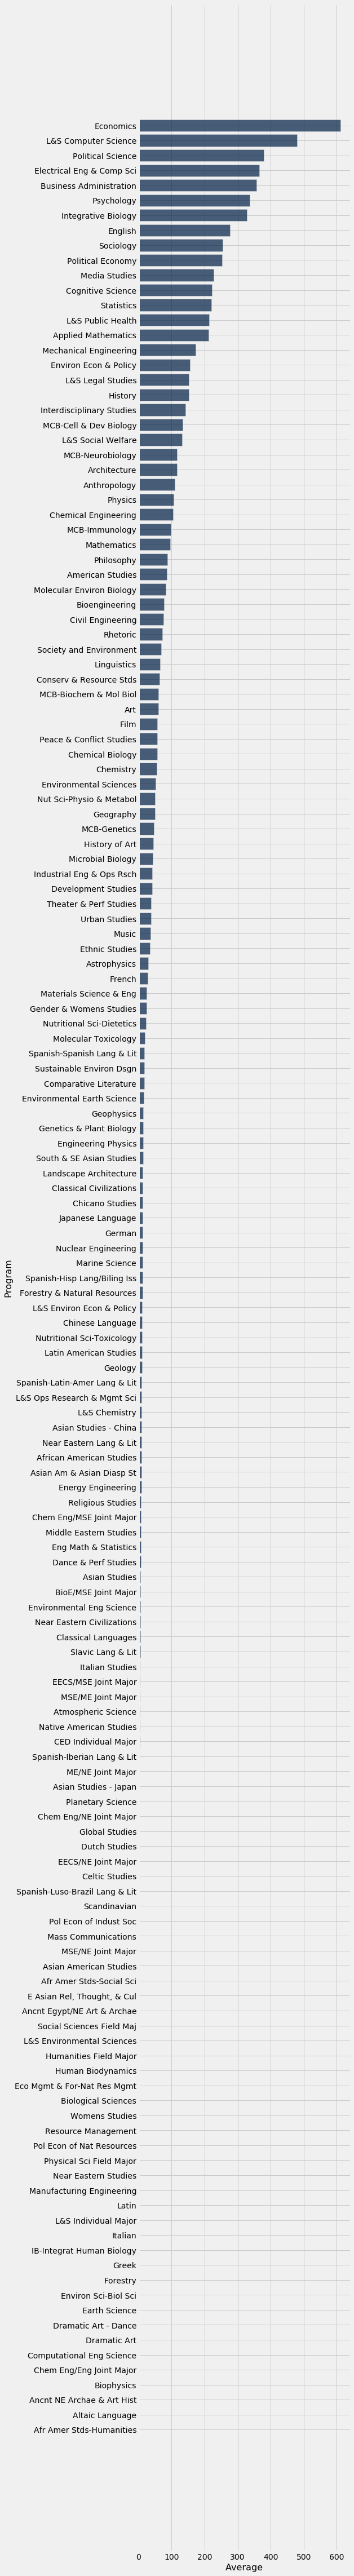

In [81]:
ave_grads(BA_by_year.after(2015)).barh('Program')

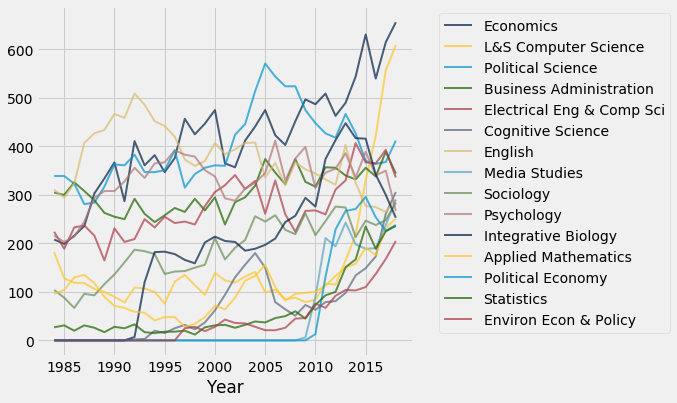

In [82]:
# Trends for the currently largest programs
BA_by_year.top(15).oplot(height=6)

In [83]:
BA_by_year.after(2010).top(20)

Year  | Economics | L&S Computer Science | Political Science | Business Administration | Electrical Eng & Comp Sci | Cognitive Science | English | Media Studies | Sociology | Psychology | Integrative Biology | Applied Mathematics | Political Economy | Statistics | Environ Econ & Policy | L&S Public Health | Mechanical Engineering | MCB-Cell & Dev Biology | L&S Legal Studies | History
2,010 | 487       | 84                   | 448               | 317                     | 268                       | 63                | 344     | 90            | 217       | 314        | 276                 | 100                 | 13                | 73         | 76                    | 139               | 165                    | 208                    | 130               | 236
2,011 | 509       | 117                  | 427               | 357                     | 260                       | 79                | 332     | 211           | 246       | 346        | 374                 | 113                 | 131               | 93         | 67                    | 198               | 132                    | 190                    | 124               | 224
2,012 | 463       | 115                  | 418               | 356                     | 311                       | 81                | 321     | 194           | 276       | 354        | 413                 | 133                 | 229               | 100        | 92                    | 153               | 185                    | 146                    | 136               | 221
2,013 | 490       | 165                  | 467               | 340                     | 330                       | 98                | 403     | 243           | 274       | 386        | 448                 | 150                 | 267               | 151        | 104                   | 125               | 164                    | 132                    | 150               | 184
2,014 | 544       | 218                  | 427               | 332                     | 407                       | 134               | 325     | 198           | 213       | 336        | 417                 | 158                 | 271               | 167        | 103                   | 170               | 150                    | 98                     | 151               | 154
2,015 | 631       | 330                  | 370               | 356                     | 367                       | 149               | 277     | 189           | 247       | 389        | 416                 | 191                 | 296               | 235        | 110                   | 184               | 168                    | 116                    | 118               | 152
2,016 | 540       | 422                  | 364               | 338                     | 365                       | 173               | 275     | 190           | 238       | 340        | 342                 | 176                 | 254               | 189        | 137                   | 253               | 185                    | 103                    | 145               | 142
2,017 | 615       | 557                  | 368               | 389                     | 393                       | 261               | 265     | 238           | 248       | 350        | 300                 | 232                 | 226               | 225        | 168                   | 218               | 161                    | 140                    | 174               | 145
2,018 | 656       | 609                  | 412               | 344                     | 336                       | 306               | 291     | 290           | 284       | 267        | 253                 | 251                 | 238               | 236        | 205                   | 200               | 180                    | 172                    | 170               | 168

In [84]:
growth(div_BA_by_year)

Program                        | Growth
Clg of Chemistry               | 3.9
Clg of Engineering             | 4.76667
Clg of Environmental Design    | -2.33333
Clg of Natural Resources       | 20.0833
Haas School of Business        | 3.06667
L&S Administered Programs      | 72.85
L&S Arts & Humanities Division | -47.6
L&S Biological Sciences Div    | -12.2
L&S Math & Phys Sciences Div   | 50.2
L&S Social Sciences Division   | 19.75
... (1 rows omitted)

In [85]:
BA_by_year.categories

['Afr Amer Stds-Humanities',
 'Afr Amer Stds-Social Sci',
 'African American Studies',
 'Altaic Language',
 'American Studies',
 'Ancnt Egypt/NE Art & Archae',
 'Ancnt NE Archae & Art Hist',
 'Anthropology',
 'Applied Mathematics',
 'Architecture',
 'Art',
 'Asian Am & Asian Diasp St',
 'Asian American Studies',
 'Asian Studies',
 'Asian Studies - China',
 'Asian Studies - Japan',
 'Astrophysics',
 'Atmospheric Science',
 'BioE/MSE Joint Major',
 'Bioengineering',
 'Biological Sciences',
 'Biophysics',
 'Business Administration',
 'CED Individual Major',
 'Celtic Studies',
 'Chem Eng/Eng Joint Major',
 'Chem Eng/MSE Joint Major',
 'Chem Eng/NE Joint Major',
 'Chemical Biology',
 'Chemical Engineering',
 'Chemistry',
 'Chicano Studies',
 'Chinese Language',
 'Civil Engineering',
 'Classical Civilizations',
 'Classical Languages',
 'Cognitive Science',
 'Comparative Literature',
 'Computational Eng Science',
 'Conserv & Resource Stds',
 'Dance & Perf Studies',
 'Development Studies',
 'D

In [86]:
DS_related = ['Economics',
 'L&S Computer Science',
 'Electrical Eng & Comp Sci',
 'Cognitive Science',
 'Applied Mathematics',
 'Statistics',
 'Industrial Eng & Ops Rsch',
 'L&S Ops Research & Mgmt Sci']

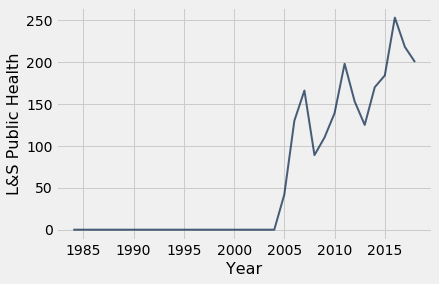

In [87]:
BA_by_year.select(['Year','L&S Public Health']).oplot()

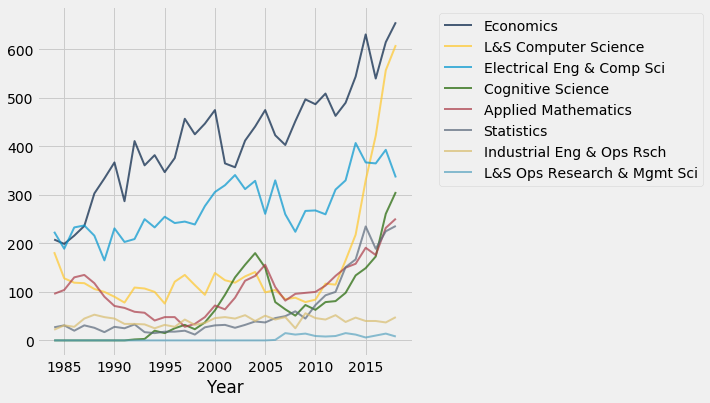

In [88]:
DS_BA_by_year = BA_by_year.select(["Year"]+DS_related)
DS_BA_by_year.oplot(height=6)

In [89]:
DS_BA_by_year['Total'] = DS_BA_by_year.sum_rows()

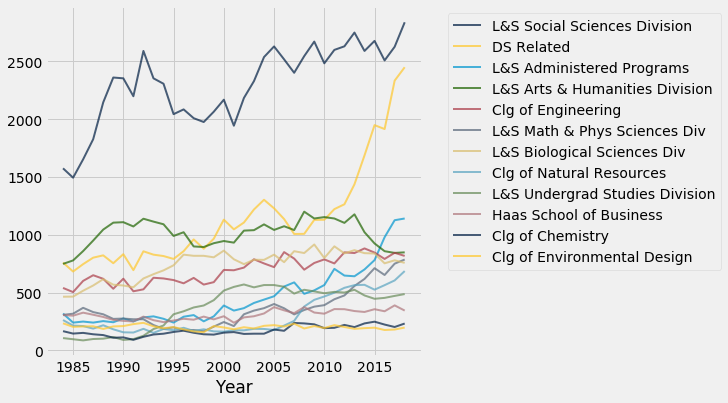

In [90]:
# Adjacent to DS overlaid on Divisional Rates
div_BA_by_year.with_column("DS Related", DS_BA_by_year["Total"]).oplot(height=6)

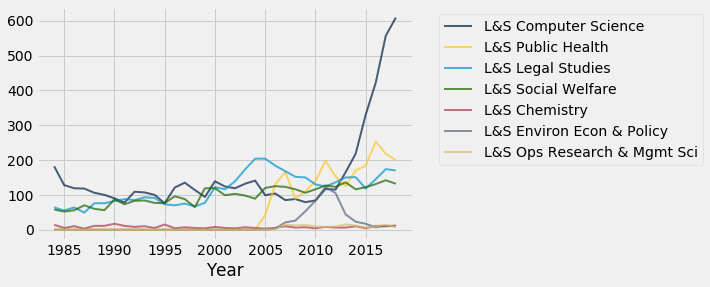

In [91]:
AP_BA_by_year = TimeTable.by_time(BA.where("Academic Division Short Nm", 
                                           "L&S Administered Programs"), 'Year', 
                                  'Major Short Nm', 'Student Headcount').oplot()


Exploring a perspective on case of what the picture might look like under assumptions of various flows if the programs connected to the Division were viewed separately from their historical Divisions to give a sense of its potential roles and responsibilities

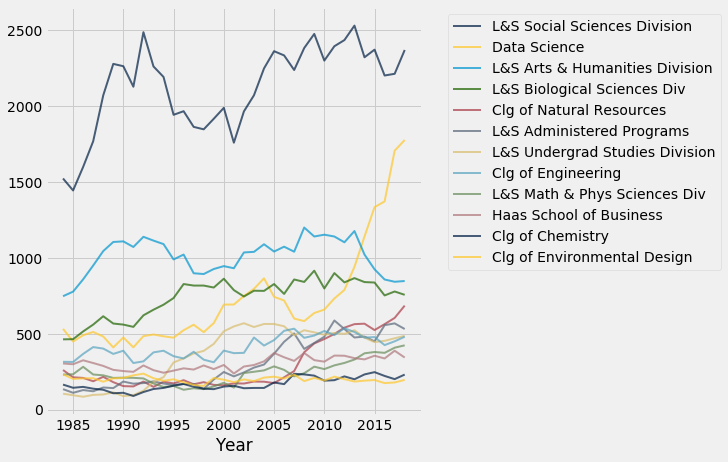

In [92]:
DS_div_BA_by_year = div_BA_by_year.with_column('Data Science', BA_by_year['L&S Computer Science'])
DS_div_BA_by_year['Data Science'] = DS_div_BA_by_year['Data Science'] + BA_by_year['Electrical Eng & Comp Sci']
DS_div_BA_by_year['Data Science'] = DS_div_BA_by_year['Data Science'] + BA_by_year['Statistics']
DS_div_BA_by_year['Data Science'] = DS_div_BA_by_year['Data Science'] + BA_by_year['Cognitive Science']
DS_div_BA_by_year['L&S Administered Programs'] -= BA_by_year['L&S Computer Science']
DS_div_BA_by_year['Clg of Engineering']        -= BA_by_year['Electrical Eng & Comp Sci']
DS_div_BA_by_year['L&S Math & Phys Sciences Div'] -= BA_by_year['Statistics']
DS_div_BA_by_year['L&S Social Sciences Division'] -= BA_by_year['Cognitive Science']

applied_math_cvt = 0.5
econ_cvt = 0.25
DS_div_BA_by_year['Data Science'] = DS_div_BA_by_year['Data Science'] + applied_math_cvt*BA_by_year['Applied Mathematics']
DS_div_BA_by_year['L&S Math & Phys Sciences Div'] = DS_div_BA_by_year['L&S Math & Phys Sciences Div'] - applied_math_cvt*BA_by_year['Applied Mathematics']

DS_div_BA_by_year['Data Science'] = DS_div_BA_by_year['Data Science'] + econ_cvt*BA_by_year['Economics']
DS_div_BA_by_year['L&S Social Sciences Division'] = DS_div_BA_by_year['L&S Social Sciences Division'] - econ_cvt*BA_by_year['Economics']

DS_div_BA_by_year.oplot(height=7)